## Вводные данные

### Описание и цель проекта
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.  

Наша `цель` — обучить на этих данных модель для прогноза оттока клиентов.

### Описание услуг

Оператор предоставляет два основных типа услуг:   
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.  
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).  

Также доступны такие услуги:  
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).  

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

### Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:  
`contract_new.csv` — информация о договоре;  
`personal_new.csv` — персональные данные клиента;  
`internet_new.csv` — информация об интернет-услугах;  
`phone_new.csv` — информация об услугах телефонии  

Файл `contract_new.csv` 
- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Файл `personal_new.csv`
- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Файл `internet_new.csv`
- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Файл `phone_new.csv`
- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

## Загрузка и первичная предобработка данных

### Импорт библиотек

In [1]:
!pip install phik
!pip install -U scikit-learn -q

In [2]:
import pandas as pd
import phik
from phik.report import plot_correlation_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

### Загрузка датасетов

In [3]:
contracts = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

### Первичный осмотр датасетов

#### contracts

In [4]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
print('Количество дубликатов', contracts.duplicated().sum())

Количество дубликатов 0


In [6]:
contracts.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


#### personal

In [7]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [8]:
print('Количество дубликатов', personal.duplicated().sum())

Количество дубликатов 0


In [9]:
personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


#### internet

In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
print('Количество дубликатов', internet.duplicated().sum())

Количество дубликатов 0


In [12]:
internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


#### phone

In [13]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [14]:
print('Количество дубликатов', contracts.duplicated().sum())

Количество дубликатов 0


In [15]:
phone.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


#### Промежуточный вывод

Датасеты `contracts` и `personal` содержат информацию по 7043 уникальным пользователям, `internet` по 5517 пользователям, а  `phone` по 6361 пользователям. Содержание датасетов соответствует их описанию.

В таблице contracts столбец TotalCharges содержит числа с плавающей точкой, однако, в типе данных object, исправим на float.

Во всех датасетах необходимо переименовать столбцы к общепринятому виду (привести к нижнему регистру с разделением слов нижним подчеркиванием).  
Во всех датасетах имеются столбцы с бинарными данными, записанными в формате Yes/No, изменим тип данных на целочисленный (int) и перепишем их, учитывая что Yes = 1, No = 0.  

### Первичная предобработка данных

Изменим тип данных столбца TotalCharges из contracts

In [16]:
contracts['TotalCharges'] = contracts['TotalCharges'].astype(str).str.strip()
contracts['TotalCharges'] = pd.to_numeric(contracts['TotalCharges'], errors='coerce')
contracts.isna().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64

Мы обнаружили 11 некорректных значений в столбце 'TotalCharges', который были заменены на Nan, пока пропуски оставим.

Изменим названия столбцов

In [17]:
sets = [contracts, personal, internet, phone]

for i in sets:
    i.rename(columns={'customerID': 'customer_id', 'StreamingTV': 'streaming_tv'}, inplace=True)
    i.columns = i.columns.str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True).str.lower()  

заменим значения в столбцах Yes/No на 1/0

for i in sets:
    for c in i.columns:
        unique_values = set(i[c].unique())
        if unique_values == {'Yes', 'No'}:
            i[c].replace({'Yes': 1, 'No': 0}, inplace=True) 

Проверим, что получилось

In [18]:
for i in sets:
    print(i.head(3))
    print('')

  customer_id  begin_date end_date            type paperless_billing  \
0  7590-VHVEG  2020-01-01       No  Month-to-month               Yes   
1  5575-GNVDE  2017-04-01       No        One year                No   
2  3668-QPYBK  2019-10-01       No  Month-to-month               Yes   

     payment_method  monthly_charges  total_charges  
0  Electronic check            29.85          31.04  
1      Mailed check            56.95        2071.84  
2      Mailed check            53.85         226.17  

  customer_id  gender  senior_citizen partner dependents
0  7590-VHVEG  Female               0     Yes         No
1  5575-GNVDE    Male               0      No         No
2  3668-QPYBK    Male               0      No         No

  customer_id internet_service online_security online_backup  \
0  7590-VHVEG              DSL              No           Yes   
1  5575-GNVDE              DSL             Yes            No   
2  3668-QPYBK              DSL             Yes           Yes   

  device

## Формирование финальной таблицы

### Объединение таблиц

объединим все таблицы по столбцу `customer_id`

In [19]:
data = pd.merge(contracts, personal, on='customer_id', how='outer')
data = pd.merge(data, internet, on='customer_id', how='outer')
data = pd.merge(data, phone, on='customer_id', how='outer')

data.head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Датасет собран успешно!
    
</div>

### Дополнительные признаки

Для начала выделим наш целевой признак (`leaving` - разорвал ли клиент договор) используя столбец `end_date`. Клиентов сразорвавших контракт (указана дата разрыва договора) пометим как 1, оставшихся клиентов пометим как 0.

In [20]:
data['leaving'] = (data['end_date'] != 'No').astype(int)

Добавим также признак (`duration`), который будет содержать продолжительность договора клента (в днях), с учетом, что данные актуальны на 1 февраля 2020 года.

In [21]:
data.loc[data['end_date'] == 'No', 'end_date'] = '2020-02-01'

data['end_date'] = pd.to_datetime(data['end_date'])
data['begin_date'] = pd.to_datetime(data['begin_date'])

data['duration'] = ((data['end_date'] - data['begin_date']).dt.days.astype(int))+1

In [22]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,leaving,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,NaN,0,32
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1037
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,124
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1372
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,154


### Удаление лишних признаков

Признаки `begin_date` и `end_date` удалим, чтобы избежать утечки данных. 

In [23]:
data = data.drop(columns=['begin_date', 'end_date'])

## Исследовательский анализ

Для начала заполним пропуски в таблице значением "no_info", пропуски в столбце total_charges оставим.

In [24]:
data[['internet_service', 
      'online_security', 
      'online_backup', 
      'device_protection',
      'streaming_tv',    
      'tech_support', 
      'streaming_movies',
      'multiple_lines']] = data[['internet_service', 
                                 'online_security', 
                                 'online_backup', 
                                 'device_protection',
                                 'streaming_tv',    
                                 'tech_support', 
                                 'streaming_movies',
                                 'multiple_lines']].fillna('no_info')

### Создание функций для визуализации

для избегания повторения кода создадим функции для визуализации категориальных признаков `visual_cat()`, а также для численных признаков `visual_num()`

In [25]:
def visual_cat(data, column, title):
    ax = data.query('leaving == 1').groupby(column)['customer_id'].count().plot(
        kind='bar',
        figsize=(8, 4),
        width=0.3,
        color='red',
        position=0,
        label='ушедшие',
        title=title,
        legend=True
    )
    
    data.query('leaving == 0').groupby(column)['customer_id'].count().plot(
        kind='bar',
        width=0.3,
        color='green',
        position=1,
        label='оставшиеся',
        ax=ax,
        grid=True,
        legend=True,
    )
    
    ax.set_ylabel('Количество сотрудников')
    
    plt.show()
    
    leave = data.query('leaving == 1').groupby(column)['customer_id'].count().sort_values(ascending=False)
    num = leave.sum()
    leave = leave.reset_index(name='count')
    leave['percentage'] = ((leave['count'] / num) * 100).round(1)
    
    noleave = data.query('leaving == 0').groupby(column)['customer_id'].count().sort_values(ascending=False)
    num = noleave.sum()
    noleave = noleave.reset_index(name='count')
    noleave['percentage'] = ((noleave['count'] / num) * 100).round(1)
    
    return ax, print('Ушедшие клиенты \n', leave), print(''), print('Оставшиеся клиенты \n', noleave)


In [26]:
def visual_num(data, column, title, bins):
    ax = data.query('leaving == 1').plot(
        kind='hist',
        y=column,
        figsize=(8, 4),        
        color='red',
        bins=bins,
        alpha=0.99,
        label='ушедшие клиенты',
        title=title
    )
    
    data.query('leaving == 0').plot(
        kind='hist',
        y=column,
        bins=bins,        
        color='green',
        alpha=0.3,
        label='оставшиеся клиенты',
        ax=ax,
        grid=True,
        legend=True
    )
    
    ax.set_ylabel('Количество клиентов')
    
    plt.show()
    
    leave = data.query('leaving == 1')[column].describe()
    noleave = data.query('leaving == 0')[column].describe()
    
    return ax, print('Ушедшие клиенты \n', leave), print(''), print('Оставшиеся клиенты \n', noleave)

### Анализ признаков

#### leaving - целевой признак

leaving
0    5942
1    1101
Name: customer_id, dtype: int64

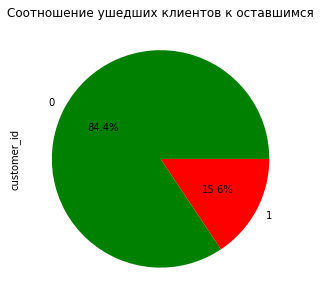

In [27]:
x=data.groupby('leaving')['customer_id'].count()

x.sort_values(ascending=False).plot(kind='pie',
                                    figsize=(5,5),
                                    autopct='%1.1f%%',
                                    legend = False,
                                    colors = ['green' if value == 0 else 'red' for value in x.index],
                                    title = 'Соотношение ушедших клиентов к оставшимся')
x.sort_values(ascending=False)

Ушедших клиентов в предоставленных данных относительно немного (15.6%), оставшихся подавляющее большинство (84.4%).

#### duration

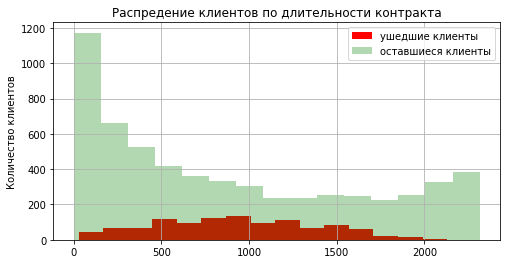

Ушедшие клиенты 
 count    1101.000000
mean      925.863760
std       458.771309
min        29.000000
25%       578.000000
50%       916.000000
75%      1250.000000
max      2130.000000
Name: duration, dtype: float64

Оставшиеся клиенты 
 count    5942.000000
mean      894.681084
std       716.958551
min         1.000000
25%       246.000000
50%       703.000000
75%      1524.000000
max      2315.000000
Name: duration, dtype: float64


In [28]:
visual_num(data, column = 'duration', bins = 15, title = 'Распредение клиентов по длительности контракта');

Распределение ушедших клиентов близко к нормальному, с нерезко выраженным пиком в области 1000 дней.  
Оставшиеся клиенты, напротив, либо совсем недавно пользуются услугами, либо очень давно, наблюдается "просадка" в средних отделах распределения.

#### type

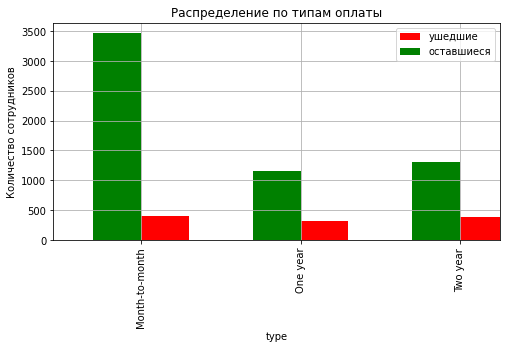

Ушедшие клиенты 
              type  count  percentage
0  Month-to-month    407        37.0
1        Two year    381        34.6
2        One year    313        28.4

Оставшиеся клиенты 
              type  count  percentage
0  Month-to-month   3468        58.4
1        Two year   1314        22.1
2        One year   1160        19.5


In [29]:
visual_cat(data, column = 'type', title = 'Распределение по типам оплаты');

Самый популярный тип оплаты у ушедших и оставшихся клиентов - ежемесячный. При этом относитльеная доля этого типа оплаты у оставшихся клиентов значительно выше по сравнению с оставшимися (58% против 37% соответственно); вероятно такое различие обусловлено новыми пользователями (наверняка новые пользователи сначала оценивают качество услуг на ежемесячной подписке, и только если их устраивают условия - они переходят на более долговременные типы подписки).

#### paperless_billing

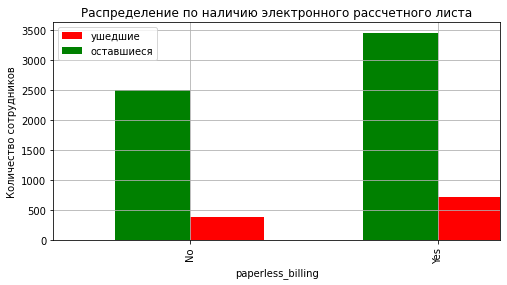

Ушедшие клиенты 
   paperless_billing  count  percentage
0               Yes    721        65.5
1                No    380        34.5

Оставшиеся клиенты 
   paperless_billing  count  percentage
0               Yes   3450        58.1
1                No   2492        41.9


In [30]:
visual_cat(data, column = 'paperless_billing', title = 'Распределение по наличию электронного рассчетного листа');

Электронный рассчетный лист у большинства клиентов имеется (относительная доля его наличия у ушедших клиентов минимально выше (65% против 58%). 

#### payment_method

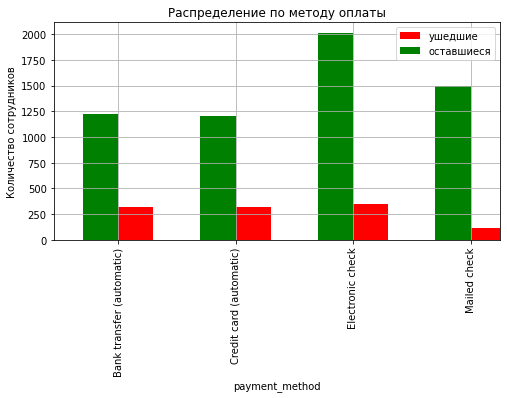

Ушедшие клиенты 
               payment_method  count  percentage
0           Electronic check    350        31.8
1  Bank transfer (automatic)    317        28.8
2    Credit card (automatic)    317        28.8
3               Mailed check    117        10.6

Оставшиеся клиенты 
               payment_method  count  percentage
0           Electronic check   2015        33.9
1               Mailed check   1495        25.2
2  Bank transfer (automatic)   1227        20.6
3    Credit card (automatic)   1205        20.3


In [31]:
visual_cat(data, column = 'payment_method', title = 'Распределение по методу оплаты');

Самый популярный метод оплаты у ушедших и оставшихся клиентов - электронный чек.  
Ушедние клиенты чаще по сравнению с оставшимися использовали банковский перевод (29% против 21%) и кредитные карты (29% против 20%), и реже использовали почтовый чек (11% против 25%).

#### monthly_charges

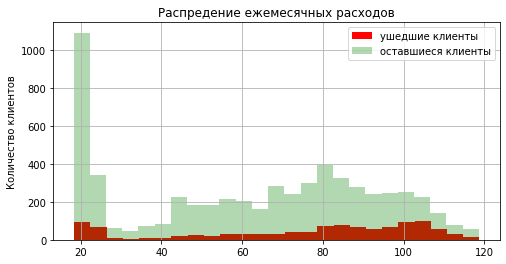

Ушедшие клиенты 
 count    1101.000000
mean       75.546004
std        29.116213
min        18.400000
25%        56.150000
50%        84.200000
75%        99.500000
max       118.750000
Name: monthly_charges, dtype: float64

Оставшиеся клиенты 
 count    5942.000000
mean       62.763455
std        29.844462
min        18.250000
25%        30.062500
50%        69.200000
75%        87.237500
max       118.600000
Name: monthly_charges, dtype: float64


In [32]:
visual_num(data, column = 'monthly_charges', bins = 25, title = 'Распредение ежемесячных расходов');

График распределения у ушедших и оставшихся клиентов в целом схож: наблюдаются два пика значений: первый в районе 20 (у оставшихся - резко выраженный, у ушедших менее выраженный), второй в диапазоне 80-100. 
Средние и медианные значения ежемесячной оплаты выше у ушедних клиентов (средние: 76 против 63, медианные: 84 против 69).

#### total_charges

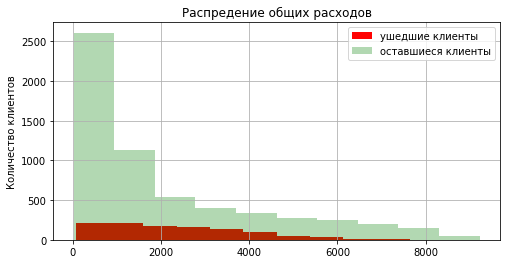

Ушедшие клиенты 
 count    1101.000000
mean     2371.377275
std      1581.862275
min        77.840000
25%      1048.050000
50%      2139.030000
75%      3404.910000
max      7649.760000
Name: total_charges, dtype: float64

Оставшиеся клиенты 
 count    5931.000000
mean     2071.701614
std      2194.122190
min        19.050000
25%       376.225000
50%      1194.280000
75%      3176.000000
max      9221.380000
Name: total_charges, dtype: float64


In [33]:
visual_num(data, column = 'total_charges', bins = 10, title = 'Распредение общих расходов');

Средние показатели расходов за всё время пользования у ушедших клиентов выше (2371 против 2071), также как и медианные значения (2139 против 1194).

#### gender

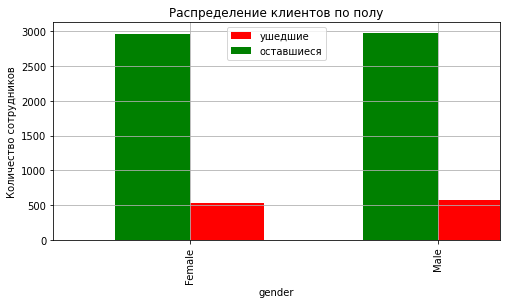

Ушедшие клиенты 
    gender  count  percentage
0    Male    573        52.0
1  Female    528        48.0

Оставшиеся клиенты 
    gender  count  percentage
0    Male   2982        50.2
1  Female   2960        49.8


In [34]:
visual_cat(data, column = 'gender', title = 'Распределение клиентов по полу');

Как ушедшие, так и оставшиеся клиенты незначительно чаще мужчины. 

#### senior_citizen

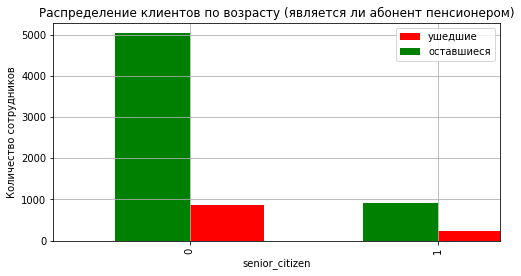

Ушедшие клиенты 
    senior_citizen  count  percentage
0               0    869        78.9
1               1    232        21.1

Оставшиеся клиенты 
    senior_citizen  count  percentage
0               0   5032        84.7
1               1    910        15.3


In [35]:
visual_cat(data, column = 'senior_citizen', title = 'Распределение клиентов по возрасту (является ли абонент пенсионером)');

Доля пенсионеров среди ушедших клиентов незначитлеьно выше (21% против 15%).

#### partner

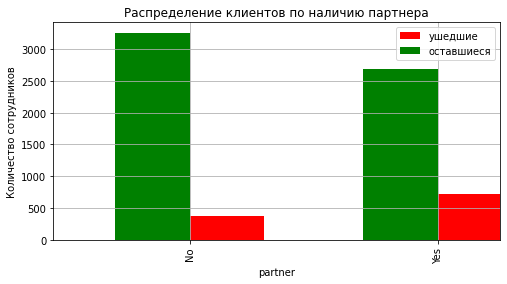

Ушедшие клиенты 
   partner  count  percentage
0     Yes    719        65.3
1      No    382        34.7

Оставшиеся клиенты 
   partner  count  percentage
0      No   3259        54.8
1     Yes   2683        45.2


In [36]:
visual_cat(data, column = 'partner', title = 'Распределение клиентов по наличию партнера');

Доля семейных пользователей среди ушедших пользователей выше (65% против 55%).

#### dependents

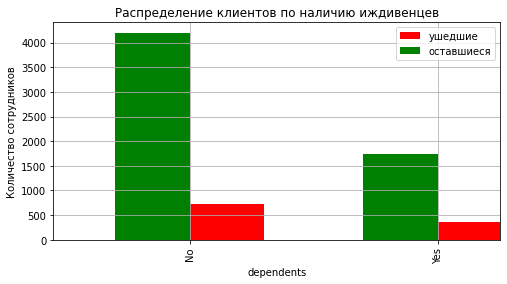

Ушедшие клиенты 
   dependents  count  percentage
0         No    733        66.6
1        Yes    368        33.4

Оставшиеся клиенты 
   dependents  count  percentage
0         No   4200        70.7
1        Yes   1742        29.3


In [37]:
visual_cat(data, column = 'dependents', title = 'Распределение клиентов по наличию иждивенцев');

Дети имеются примерно у трети всех клиентов (33% среди ушедших и 29% среди оставшихся).

#### internet_service

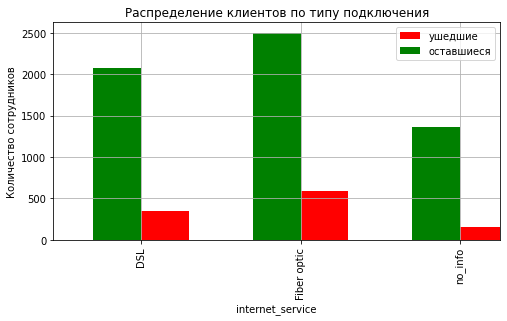

Ушедшие клиенты 
   internet_service  count  percentage
0      Fiber optic    595        54.0
1              DSL    346        31.4
2          no_info    160        14.5

Оставшиеся клиенты 
   internet_service  count  percentage
0      Fiber optic   2501        42.1
1              DSL   2075        34.9
2          no_info   1366        23.0


In [38]:
visual_cat(data, column = 'internet_service', title = 'Распределение клиентов по типу подключения');

Ушедшие клиенты чаще пользовались фиброволокном (54% против 42%) и реже DSL (31% против  35%).

#### online_security

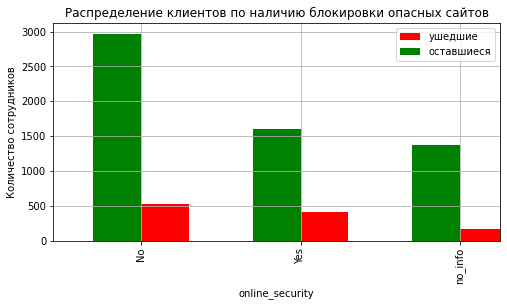

Ушедшие клиенты 
   online_security  count  percentage
0              No    526        47.8
1             Yes    415        37.7
2         no_info    160        14.5

Оставшиеся клиенты 
   online_security  count  percentage
0              No   2972        50.0
1             Yes   1604        27.0
2         no_info   1366        23.0


In [39]:
visual_cat(data, column = 'online_security', title = 'Распределение клиентов по наличию блокировки опасных сайтов');

Ушедшие клиенты чаще пользовались блокировкой опасных сайтов (38% против 27%).

#### online_backup

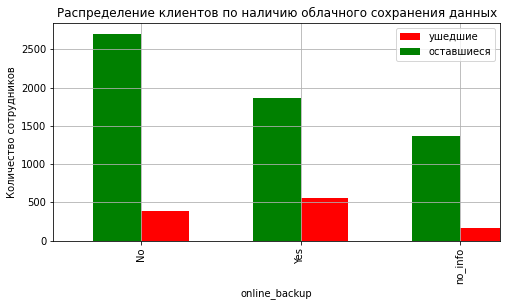

Ушедшие клиенты 
   online_backup  count  percentage
0           Yes    560        50.9
1            No    381        34.6
2       no_info    160        14.5

Оставшиеся клиенты 
   online_backup  count  percentage
0            No   2707        45.6
1           Yes   1869        31.5
2       no_info   1366        23.0


In [40]:
visual_cat(data, column = 'online_backup', title = 'Распределение клиентов по наличию облачного сохранения данных');

Ушедшие клиеты значительно чаще пользовались облачным сервисом (51% против  32%).

#### device_protection

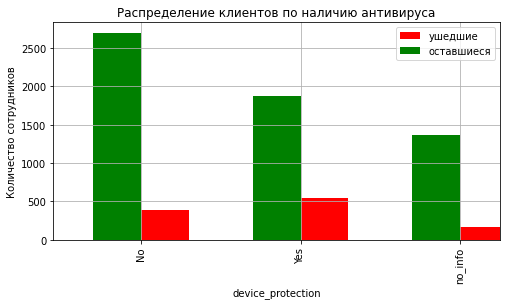

Ушедшие клиенты 
   device_protection  count  percentage
0               Yes    550        50.0
1                No    391        35.5
2           no_info    160        14.5

Оставшиеся клиенты 
   device_protection  count  percentage
0                No   2704        45.5
1               Yes   1872        31.5
2           no_info   1366        23.0


In [41]:
visual_cat(data, column = 'device_protection', title = 'Распределение клиентов по наличию антивируса');

Ушедшие клиеты значительно чаще пользовались антивирусом (50% против  32%).

#### tech_support

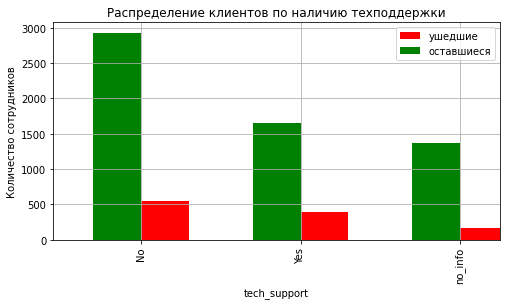

Ушедшие клиенты 
   tech_support  count  percentage
0           No    543        49.3
1          Yes    398        36.1
2      no_info    160        14.5

Оставшиеся клиенты 
   tech_support  count  percentage
0           No   2930        49.3
1          Yes   1646        27.7
2      no_info   1366        23.0


In [42]:
visual_cat(data, column = 'tech_support', title = 'Распределение клиентов по наличию техподдержки');

Процент пользования технической поддержкой среди ушедших клиентов несколько выше (36% против 28%).

#### streaming_tv

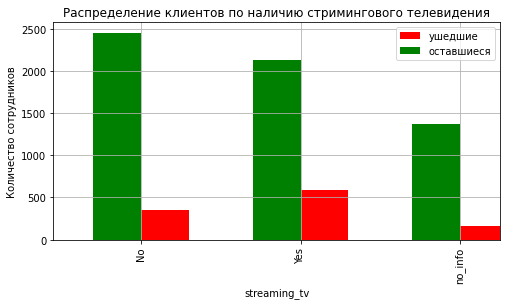

Ушедшие клиенты 
   streaming_tv  count  percentage
0          Yes    584        53.0
1           No    357        32.4
2      no_info    160        14.5

Оставшиеся клиенты 
   streaming_tv  count  percentage
0           No   2453        41.3
1          Yes   2123        35.7
2      no_info   1366        23.0


In [43]:
visual_cat(data, column = 'streaming_tv', title = 'Распределение клиентов по наличию стримингового телевидения');

Ушедшие клиеты значительно чаще пользовались стриминговым ТВ (53% против  36%).

#### streaming_movies

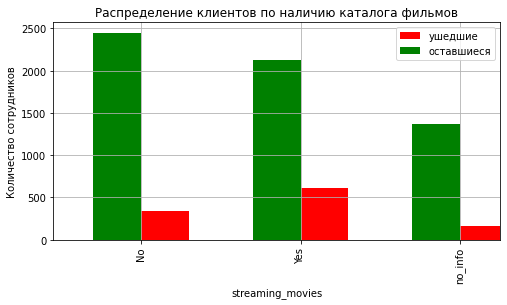

Ушедшие клиенты 
   streaming_movies  count  percentage
0              Yes    606        55.0
1               No    335        30.4
2          no_info    160        14.5

Оставшиеся клиенты 
   streaming_movies  count  percentage
0               No   2450        41.2
1              Yes   2126        35.8
2          no_info   1366        23.0


In [44]:
visual_cat(data, column = 'streaming_movies', title = 'Распределение клиентов по наличию каталога фильмов');

Ушедшие клиеты значительно чаще пользовались каталогом фильмов (55% против 36%).

#### multiple_lines

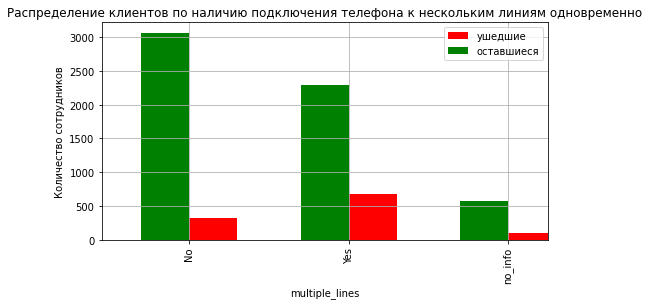

Ушедшие клиенты 
   multiple_lines  count  percentage
0            Yes    678        61.6
1             No    320        29.1
2        no_info    103         9.4

Оставшиеся клиенты 
   multiple_lines  count  percentage
0             No   3070        51.7
1            Yes   2293        38.6
2        no_info    579         9.7


In [45]:
visual_cat(data, column = 'multiple_lines', title = 'Распределение клиентов по наличию подключения телефона к нескольким линиям одновременно');

Ушедшие клиеты значительно чаще были подключены к нескольким телефонным линиям (62% против 39%).

#### Выводы по признакам

Доля ушедших клиентов в выборке составляет 15.6%.  
В среднем клиенты уходят через 900 дней пользования (2,5 года).  
Ушедние клиенты чаще по сравнению с оставшимися использовали банковский перевод (29% против 21%) и кредитные карты (29% против 20%), и реже использовали почтовый чек (11% против 25%).  

Средние и медианные значения ежемесячной оплаты, а также расходов за всё время выше у ушедних клиентов.

Доля семейных пользователей среди ушедших пользователей выше (65% против 55%). 

Ушедшие клиенты чаще пользовались фиброволокном (54% против 42%) и реже DSL (31% против 35%).  
Ушедшие клиенты чаще пользовались блокировкой опасных сайтов, облачным сервисом, антивирусом, технической поддержкой, стриминговым ТВ с каталогом фильмов, а также чаще были подключены с нескольким телефонным линиям. 

Можно предположить, что:
- ушедшие клиенты более технически подкованы (т.к. доля использующих почтовый чек среди оставшихся клиентов сильно выше, для таких клиентов любой интернет - чудо, поэтому они и реже уходят);
- ушедших клиентов не устраивало качество предоставляемых дополнительных платных услуг (доля таких услуг значительно выше у ушедших клиентов, как и их среднемесячные и совокупные расходы), что в частности заметно среди семейных пар, более осознанно подходящих к решению таких вопросов (одна голова хорошо, а две - лучше).

### Корреляционная матрица

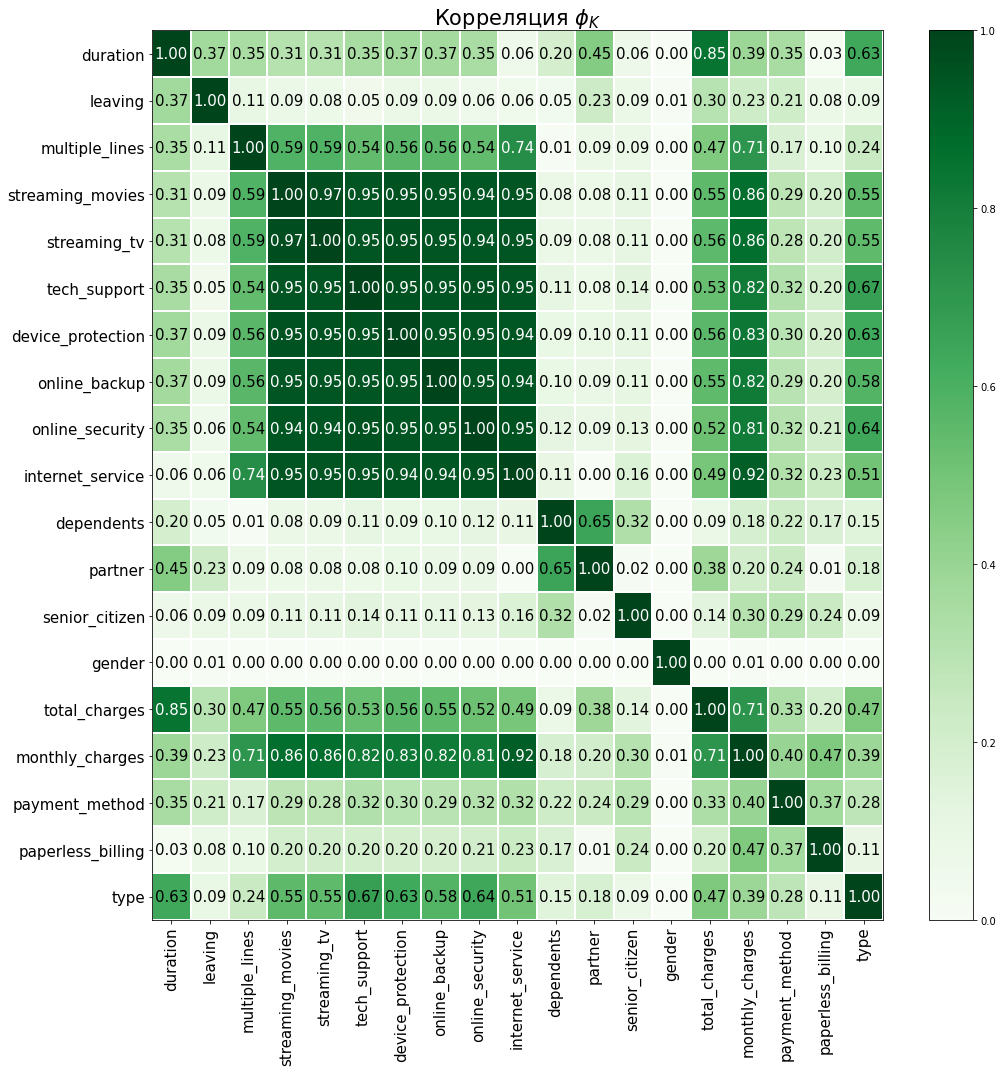

In [46]:
interval_cols = ['duration', 'monthly_charges', 'total_charges']

phik_overview = data.drop('customer_id', axis=1).phik_matrix(interval_cols=interval_cols) 

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 15))
plt.tight_layout()

По корреляционной матрице можно заметить, что у нашего целевого признака `leaving` отмечается нерезкая прямая корреляция с признаками:  
- `duration` (длительность контракта)- 0.37,  
- `total_charges` (совокупные расходы) - 0.3,  
- `monthly_charges` (ежемесячные расходы) - 0.23,  
- `partner` (наличие партнера) - 0.23,
- `payment_method` (способ оплаты) - 0.21.  

Остальные признаки показывают низкие коэффициенты прямой корреляции, с самым низким у признака `gender` (пол  клиента) - 0.01.


Отмечается выраженная мультиколлинеарность (0.94-0.97) между признаками, отражающими дополнительные платные услуги (`tech_support`, `online_backup`, `online_security`, `device_protection`, `streaming_tv`, `streaming_movies`).

## Обучение моделей

### Подготовка данных

In [47]:
data.dropna(inplace=True)

Уберем оставшиеся пропуски (это 11 строк с пропусками в столбце общих расходов) - это незначительная часть данных, можем смело убрать.  

Также можем убрать незначительный (по корреляции с целевым) признак `gender`. Также из списка признаков с высокой мультиколлинеарностью (tech_support', 'online_backup', 'online_security', 'device_protection', 'streaming_tv', 'streaming_movies') оставим один `streaming_movies`.

In [48]:
RANDOM_STATE = 70425
TEST_SIZE = 0.25

X = data.drop(['leaving', 'customer_id', 'gender', 'tech_support',
               'online_backup', 'online_security', 'device_protection',
               'streaming_tv'], axis=1)
y = data['leaving']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE, test_size = TEST_SIZE, stratify = y)

In [49]:
ohe_columns = ['type', 'paperless_billing', 'payment_method',
       'senior_citizen', 'partner', 'internet_service', 
       'streaming_movies', 'multiple_lines', 'dependents']

num_columns = ['monthly_charges', 'total_charges', 'duration']

In [50]:
data_preprocessor = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error'), ohe_columns),
    ('num', StandardScaler(), num_columns)], 
    remainder='passthrough'
)

### LogisticRegression

In [51]:
pipe_final = Pipeline([('preprocessor', data_preprocessor),
                       ('models', LogisticRegression(random_state=RANDOM_STATE))])

param_grid = [{'models': [LogisticRegression(random_state=RANDOM_STATE,
                                             class_weight='balanced',
                                             solver='liblinear')],
               'models__C': [1, 3, 5, 7],  
               'models__penalty': ['l1', 'l2'],
               'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
              }]

grid_lr = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1)

grid_lr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_lr.best_estimator_)
print ('Метрика ROC-AUC лучшей модели :', grid_lr.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'internet_service',
                                                   'streaming_movies',
                                                   'multiple_lines',
                                                   'dependents']),
                                                 ('num', MinMaxScaler(),
                                                  ['monthly_charges',
                                                   'total_charges',
                     

### DecisionTreeClassifier

In [52]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])

param_grid = [{'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
               'models__max_depth': [3, 5, 7, 9, 11, 15],
               'models__max_features': range(2, 10),
               'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
              }]

grid_dtc = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1)

grid_dtc.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_dtc.best_estimator_)
print ('Метрика ROC-AUC лучшей модели :', grid_dtc.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'internet_service',
                                                   'streaming_movies',
                                                   'multiple_lines',
                                                   'dependents']),
                                                 ('num', MinMaxScaler(),
                                                  ['monthly_charges',
                                                   'total_charges',
                     

### CatBoostClassifier

In [53]:
pipeline_cat = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', CatBoostClassifier(silent = True, random_state=RANDOM_STATE))
])

param_grid_cat = {
    'model__depth': range(2, 6),
    'model__learning_rate': [0.2, 0.25, 0.5],    
    'model__n_estimators': [500, 1000],
    'model__l2_leaf_reg': [1, 3, 5, 7]  
}

grid_cat = GridSearchCV(
    pipeline_cat, 
    param_grid_cat, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1)

grid_cat.fit(X_train, y_train)

print('Параметры лучшей модели\n', grid_cat.best_params_)
print ('Метрика ROC-AUC лучшей модели :', grid_cat.best_score_)

Параметры лучшей модели
 {'model__depth': 2, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.2, 'model__n_estimators': 1000}
Метрика ROC-AUC лучшей модели : 0.9311709391790787


По итогам перебора гиперпараметров, была получена лучшая модель `CatBoostClassifier` с параметрами `{'model__depth': 2, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.2, 'model__n_estimators': 1000}` с метрикой ROC_AUC на кросс-валидации: 93.1 

## Тестирование лучшей модели.

Оценим нашу лучшую модель на тестовой выборке.

In [54]:
predictions_proba = grid_cat.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, predictions_proba)

print ('Метрика ROC-AUC лучшей модели на тестовой выборке:', roc_auc)

Метрика ROC-AUC лучшей модели на тестовой выборке: 0.9337890026359345


Полученный результат (0.93) удовлетворяет требованию заказчика (>0.85).

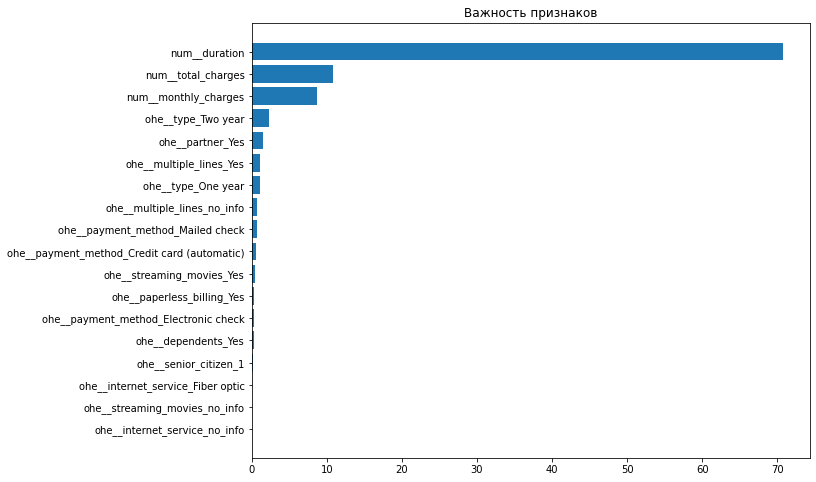

In [67]:
imp_df = pd.DataFrame({
        'Признак': grid_cat.best_estimator_[:-1].get_feature_names_out(),
        'Важность': grid_cat.best_estimator_[-1].feature_importances_}).sort_values(by='Важность', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(imp_df['Признак'], imp_df['Важность'])
plt.title(f'Важность признаков')
plt.gca().invert_yaxis()
plt.show()

С большм отрывом лидирует признак `duration`, отражающий длительность контракта клиента; затем ожидаемое 2-е и 3-е места по важности занимают  расходы за всё время `total_charges` и с небольшим отрывом ежемесячные расходы `monthly_charges`. Остальные признаки сильно уступают в важности.   

При необходимости можно было бы попробовать убрать малозначимые признаки и посмотреть как отреагирует целевая метрика.

## Общий вывод и рекомендации заказчику.

Перед нами была поставлена задача научиться предсказывать отток клиентов компании «ТелеДом».  
Были предоставлены данные из четырех датасетов, описывающие в общей сложности более 7 тысяч клиентов.

Была проведена проектная работа в виде:
- предобработки данных (приведение табличных значений в нужные типы данный, переименование столбцов, заполнение пропусков);  
- выделения целевого признака (`leaving`), отражающего расторг ли клиент контракт), а также дополнительного признака (`duration`), отражающего продолжительность обслуживания клиента в днях;  
- формирования из предоставленных 4-х таблиц одной общей таблицы;  
- исследовательского анализа всех признаков (в сравнении ушедших клиентов с оставшимися);
- построения корреляционной матрицы и отбора признаков для машинного обучения; 
- обучения (с перебором различных гиперпараметров) трех алгоритмов машинного обучения LogisticRegression, DesicionTreeClassifier и CatBoostClassifier; выделения лучшей модели (`CatBoostClassifier` с параметрами `{'model__depth': 2, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.2, 'model__n_estimators': 1000}`) и её успешного тестирования (метрика ROC-AUC = 0.93, при необходимом значении 0.85).

В ходе машинного обучения самыми важными признаками при предсказании оттока клиентов оказались признак `duration`, отражающий длительность контракта клиента (значительно более важный по сравнению с остальными); расходы за всё время `total_charges` и ежемесячные расходы `monthly_charges`. Остальные признаки сильно уступают в важности, однако недооценивать их не стоит. В частности при проведении исследовательского анализа был сформирован портрет ушедших клиентов:
- это люди чаще пользующиеся дополнительными платными услугами (доля таких услуг значительно выше у ушедших клиентов, как и их среднемесячные и совокупные расходы по сравнению с оставшимися).  
- ушедшие клиенты более технически подкованы (т.к. отдают предпочтение современным методам оплаты);   
- также это чаще семейные люди.  

Можно порекомендовать заказчику проверить (и при возможности учучшить) качество предоставляемых доп.услуг.
Также для улучшения качества модели машинного обучения, можно порекомендовать более тщательный (в предоставленных сейчас данных было много пропусков), а также более подробный сбор информации о клиенте (такие признаки как возраст и место жительства, могут сильно помочь).